In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from functools import reduce
from qulacs import QuantumState, QuantumCircuit
from qulacsvis import circuit_drawer
import matplotlib as mpl

mpl.rcParams.update({'font.size': 18})

## seed of random number
random_seed = 353
## initialization of random number generator
np.random.seed(random_seed)

# Dinámica de sistema de varios cuerpos
Simulamos el comportamiento de los valores de expectación de un sistema de 10 espines cuyo comportamiento está descripto por un Hamiltoniano de Ising. Para ello, trabajamos con un circuito de 6 qubits cuyos parámetros se optimizan utilizando QCL.



Es necesario notar que estaremos trabajando con dos sistemas:

- El sistema "real" del que tomamos los datos para entrenar nuestro circuito. En la práctica, estos datos podrían ser obtenidos experimentalmente de un sistema cuántico cuyo hamiltoniano se desconozca. En este caso, simulamos un sistema de 10 espines al que le asociamos el Hamiltoniano $H_{sys}$. 

- El sistema asociado al circuito cuántico que parametrizamos al que le asociamos el Hamiltoniano $H_{circ}$. Utilizaremos un sistema de 6 qubits con 6 capas.

In [2]:
n_system = 10   ## dimension of real system
nqubit = 6      ## number of qubits in the parametric circuit
c_depth = 6     ## circuit layers

### Librería qulacs

Para simular los comportamientos de sistemas cuánticos se utiliza la librería qulacs. 

Por ejemplo, en las siguientes líneas importamos las matrices de Pauli X y Z que actúan en un solo qubit.

In [3]:
## Basic gate
from qulacs.gate import X, Z
I_mat = np.eye(2, dtype=complex)
X_mat = X(0).get_matrix() 
Z_mat = Z(0).get_matrix() 

Definimos la función ```make_fullgate```  para crear operadores aplicables al sistema completo a partir de operadores o compuertas que actúan en un único spin o qubit. 

Estas funciones toman dos argumentos: ```list_SiteAndOperator``` y ```nqubit```.

```list_SiteAndOperator``` es una lista de listas, cada una de las cuales contiene un sitio y el operador que actúa en ese sitio.

```nqubit``` es el número de componentes del sistema. 

In [4]:
## Function that creates fullsize gate.
def make_fullgate(list_SiteAndOperator, nqubit):
    '''
    Take list_SiteAndOperator = [ [i_0, O_0], [i_1, O_1], ...],
    Insert Identity into unrelated qubit
    make (2**nqubit, 2**nqubit) matrix:
    I(0) * ... * O_0(i_0) * ... * O_1(i_1) ...
    '''
    list_Site = [SiteAndOperator[0] for SiteAndOperator in list_SiteAndOperator]
    list_SingleGates = [] ## Arrange 1-qubit gates and reduce with np.kron
    cnt = 0
    for i in range(nqubit):
        if (i in list_Site):
            list_SingleGates.append( list_SiteAndOperator[cnt][1] )
            cnt += 1
        else: ## an empty site is identity
            list_SingleGates.append(I_mat)

    return reduce(np.kron, list_SingleGates)


### Generación artificial de datos etiquetados

En primer lugar, vamos a generar los datos para "entrenar" al circuito.

Para ello, utilizaremos el Hamiltoniano dado por:

$H_{sys} = \sum\limits^N_{j=1} a_j X_j + \sum\limits^N_{j=1}\sum\limits^{j-1}_{k=1} J_{jk}Z_jZ_k$

Los coeficientes $a_j$ y $J_{jk}$ se generan aleatoriamente con valores entre [-1,1]. 

In [5]:
ham = np.zeros((2**n_system,2**n_system), dtype = complex)

for i in range(n_system): ## i runs 0 to n_system-1
    Jx = -1. + 2.*np.random.rand() ## random number in -1~1
    ham += Jx * make_fullgate( [ [i, X_mat] ], n_system)
    for j in range(i+1, n_system):
        J_ij = -1. + 2.*np.random.rand()
        ham += J_ij * make_fullgate ([ [i, Z_mat], [j, Z_mat]], n_system)

diag, eigen_vecs = np.linalg.eigh(ham)

### Observables a medir

Deseamos reproducir el comportamiento de los valores de expectación de la magnetización en Z de los primeros 5 qubits. Por lo que generamos los operadores asociados, con las dimensiones de $H_{sys}$.

In [6]:
# Define observables to be measured
from qulacs import Observable

z0 = Observable(n_system)
z0.add_operator(1.,'Z 0') # a = 1

z1 = Observable(n_system)
z1.add_operator(1.,'Z 1') # a = 1

z2 = Observable(n_system)
z2.add_operator(1.,'Z 2') # a = 1

z3 = Observable(n_system)
z3.add_operator(1.,'Z 3') # a = 1

z4 = Observable(n_system)
z4.add_operator(1.,'Z 4') # a = 1

In [7]:
z0_train_results = np.asarray([])
z1_train_results= np.asarray([])
z2_train_results = np.asarray([])
z3_train_results = np.asarray([])
z4_train_results = np.asarray([])

## Evolución 

Con $H_{sys}$ ya generado, simulamos la evolución real y guardamos los valores de expectación de los primeros 5 qubits. 

Siguiendo las indicaciones del trabajo de referencia:

- Se inicializa el sistema en el estado $\ket{0}^{\otimes 10}$. 

- Se descarta un tiempo transitorio de $T_{transient} = 300$. 

- Se simula el sistema en el intervalo $[T_{transient},T_{transient}+8]$. Mapeando estos tiempos al intervalo $[-1,1]$ según: $t = 4x+1$. 

In [10]:
x_times = np.linspace(-1,1,100) # tiempos parametrizados
t_transition = 300
times = 4*(x_times+1)+t_transition # tiempos reales

Para estos tiempos, "medimos" los valores de expectación de los observables elegidos y los almacenamos como etiquetas. Así, a cada etiqueta ${x_i}$ (asociada al tiempo $t_i$) le corresponderá una etiqueta dada por un vector de 5 componentes.

In [11]:
from qulacs.gate import DenseMatrix

## Time evolution
for time_step in times:
    ## Define quantum state
    state = QuantumState(n_system)
    state.set_zero_state()
    ## Create a time evolution operator by diagonalization. H*P = P*D <-> H = P*D*P^dagger

    time_evol_op = np.dot(np.dot(eigen_vecs, np.diag(np.exp(-1j*time_step*diag))), eigen_vecs.T.conj()) # e^-iHT
    time_evol_gate = DenseMatrix([i for i in range(n_system)], time_evol_op)

    # Apply time evolution operator

    time_evol_gate.update_quantum_state(state)

    noise_percent = 0.1

    z0_val = z0.get_expectation_value(state)
    z0_noise = np.random.normal(0, (z0_val**2)*noise_percent)
    z0_train_results = np.append(z0_train_results, z0_val+z0_noise)
    z1_val = z1.get_expectation_value(state)
    z1_noise = np.random.normal(0, (z1_val**2)*noise_percent)
    z1_train_results= np.append(z1_train_results,z1_val+z1_noise)
    z2_val = z2.get_expectation_value(state)
    z2_noise = np.random.normal(0, (z2_val**2)*noise_percent)
    z2_train_results = np.append(z2_train_results, z2_val+z2_noise)
    z3_val = z3.get_expectation_value(state)
    z3_noise = np.random.normal(0, (z3_val**2)*noise_percent)
    z3_train_results = np.append(z3_train_results, z3_val+z3_noise)
    z4_val = z4.get_expectation_value(state)
    z4_noise = np.random.normal(0, (z4_val**2)*noise_percent)
    z4_train_results = np.append(z4_train_results, z4_val+z4_noise)


train_results = [np.asarray([z0_train_results[i], z1_train_results[i], z2_train_results[i],z3_train_results[i],z4_train_results[i]]) for i in range(len(z0_train_results))]

# Datos de entrenamiento resultantes

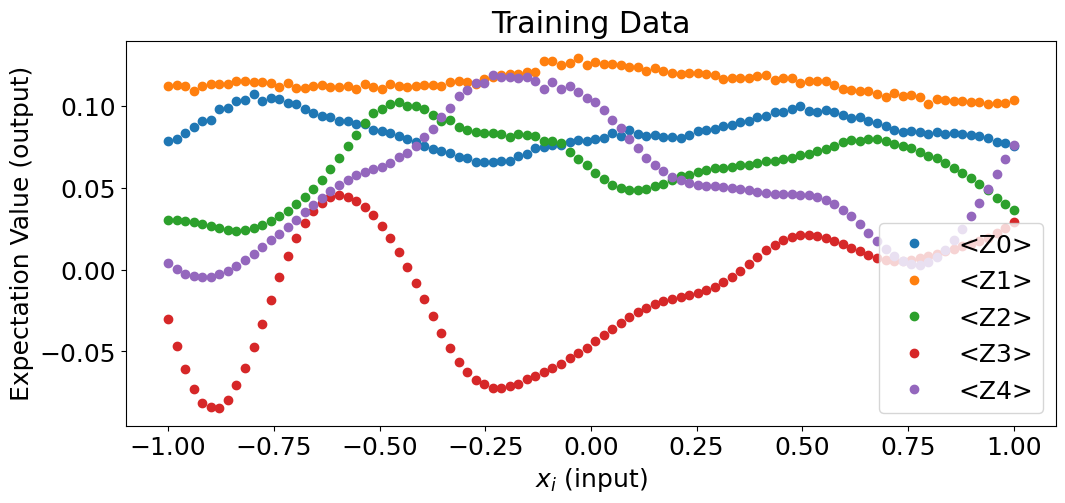

In [13]:
fig,axs = plt.subplots(1,figsize=(12,5), clear=True)
plt.title('Training Data')
axs.set_xlabel('$x_i$ (input)')
axs.set_ylabel('Expectation Value (output)')
axs.plot(x_times, z0_train_results,'o', label = '<Z0>');axs.plot(x_times, z1_train_results, 'o',label = '<Z1>');axs.plot(x_times, z2_train_results, 'o',label = '<Z2>');axs.plot(x_times, z3_train_results, 'o',label = '<Z3>');axs.plot(x_times, z4_train_results, 'o',label = '<Z4>')
plt.legend(loc = 'lower right')
plt.show()

## Codificación de input en estado cuántico

Es necesario codificar el conjunto ${x_i}$ asociado a los tiempos en estados cuánticos. Para eso, creamos la compuerta $U_{in}(x_i)$ que transformará los estados $\ket{00...0}$ usando compuertas de rotación. Siguiendo el trabajo de referencia, definimos:

$U_{in}(\mathbf{x_{i}}) \ =\ \prod _{j} R_{j}^{Z}\left(\cos^{-1} x_{i}^{2}\right) R_{j}^{Y}\left(\sin^{-1} x_{i}\right)$

De esta forma el input $x_i$, se codifica según: $\ket{\psi_{in}(x_i)} = U_{in}(x_i)\ket{00...0}$

In [16]:
# Function that creats a gate encoding x
def U_in(x):
    U = QuantumCircuit(nqubit)

    angle_y = np.arcsin(x)
    angle_z = np.arccos(x**2)

    for i in range(nqubit):
        U.add_RY_gate(i, angle_y)
        U.add_RZ_gate(i, angle_z)

    return U

En el siguiente ejemplo, podemos ver cómo codificamos el valor $x=0.1$ en un estado inicializado como $\ket{000000}$

In [24]:
# Initial State
state = QuantumState(nqubit) # Initial state |000000>
state.set_zero_state()

# Test initial state
x = 0.1 # appropriate value
U_in(x).update_quantum_state(state) # calculation of U_in|000>
print(np.round(state.get_vector(),8))

[-2.977103e-02-9.9205338e-01j  4.973974e-02-9.9494000e-04j
  4.973974e-02-9.9494000e-04j  2.494000e-05+2.4936100e-03j
  4.973974e-02-9.9494000e-04j  2.494000e-05+2.4936100e-03j
  2.494000e-05+2.4936100e-03j -1.250000e-04+0.0000000e+00j
  4.973974e-02-9.9494000e-04j  2.494000e-05+2.4936100e-03j
  2.494000e-05+2.4936100e-03j -1.250000e-04+0.0000000e+00j
  2.494000e-05+2.4936100e-03j -1.250000e-04-0.0000000e+00j
 -1.250000e-04-0.0000000e+00j  6.000000e-08-6.2700000e-06j
  4.973974e-02-9.9494000e-04j  2.494000e-05+2.4936100e-03j
  2.494000e-05+2.4936100e-03j -1.250000e-04+0.0000000e+00j
  2.494000e-05+2.4936100e-03j -1.250000e-04-0.0000000e+00j
 -1.250000e-04-0.0000000e+00j  6.000000e-08-6.2700000e-06j
  2.494000e-05+2.4936100e-03j -1.250000e-04+0.0000000e+00j
 -1.250000e-04+0.0000000e+00j  6.000000e-08-6.2700000e-06j
 -1.250000e-04+0.0000000e+00j  6.000000e-08-6.2700000e-06j
  6.000000e-08-6.2700000e-06j  3.100000e-07+1.0000000e-08j
  4.973974e-02-9.9494000e-04j  2.494000e-05+2.4936100e-0

La librería qulacs_viz nos permite visualizar la compuerta de entrada resultante

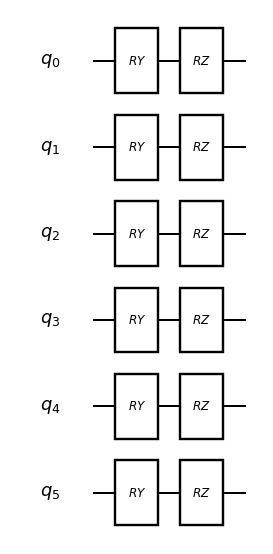

In [25]:
circuit_drawer(U_in(x),'mpl')

## Circuito Cuántico Parametrizado

A continuación, generamos el circuito cuántico que vamos a optimizar. 

Este consiste de 6 capas. Cada una, a su vez, formada por un operador evolución asociado a las interacciones del sistema ($H_{circ}$) y por una serie de compuertas de rotación.

Para $H_{circ}$ también utilizamos un Hamiltoniano de Ising con coeficientes $a_j$ y $J_{jk}$ generados aleatoriamente con valores entre [-1,1].

$H_{circ} = \sum\limits^{N_{qubits}}_{j=1} a_j X_j + \sum\limits^{N_{qubits}}_{j=1}\sum\limits^{j-1}_{k=1} J_{jk}Z_jZ_k$

Crearemos el operador evolución asociado: 
$U_{circ} = e^{-iH_{circ}t}$

In [27]:
## seed of random number
random_seed = 0
## initialization of random number generator
np.random.seed(random_seed)

In [28]:
time_step = 10 ## elapsed time of time evolution with random Hamiltonian
ham = np.zeros((2**nqubit,2**nqubit), dtype = complex)

for i in range(nqubit): ## i runs 0 to nqubit-1
    Jx = -1. + 2.*np.random.rand() ## random number in -1~1
    ham += Jx * make_fullgate( [ [i, X_mat] ], nqubit)
    for j in range(i+1, nqubit):
        J_ij = -1. + 2.*np.random.rand()
        ham += J_ij * make_fullgate ([ [i, Z_mat], [j, Z_mat]], nqubit)

## Create a time evolution operator by diagonalization. H*P = P*D <-> H = P*D*P^dagger
diag, eigen_vecs = np.linalg.eigh(ham)
time_evol_op = np.dot(np.dot(eigen_vecs, np.diag(np.exp(-1j*time_step*diag))), eigen_vecs.T.conj()) # e^-iHT

# Convert to qulacs gate
time_evol_gate = DenseMatrix([i for i in range(nqubit)], time_evol_op)

En cada capa aplicaremos tres compuertas de rotación

$U_{rot}(\theta_j^{(i)}) = R^X_j(\theta^{(i)}_{j1})R^Z_j(\theta^{(i)}_{j2})R^X_j(\theta^{(i)}_{j3})$

En total se tienen $3 \times N_{qubits} \times d$ parametros. 

Los valores iniciales para $\theta$ se eligen aleatoriamente de una distribución uniforme en $\left[ 0,2 \pi \right]$ 


In [29]:
from qulacs import ParametricQuantumCircuit

# Assemble output gate U_out & set initial parameter values
U_out = ParametricQuantumCircuit(nqubit)
for d in range(c_depth):
    U_out.add_gate(time_evol_gate)
    for i in range(nqubit):
        angle = 2.0 * np.pi * np.random.rand()
        U_out.add_parametric_RX_gate(i,angle)
        angle = 2.0 * np.pi * np.random.rand()
        U_out.add_parametric_RZ_gate(i,angle)
        angle = 2.0 * np.pi * np.random.rand()
        U_out.add_parametric_RX_gate(i,angle)
        
# Get the list of initial values of the parameter theta
parameter_count = U_out.get_parameter_count()
theta_init = [U_out.get_parameter(ind) for ind in range(parameter_count)]

De esta forma, el circuito variacional completo $U(\theta)$ es:

$U\left(\{ \theta^{(i)}_{j} \}_{i,j} \right) = \prod\limits_{i=1}^d \left( \left( \prod\limits_{j=1}^n U_{rot}(\theta_j^{(i)}) \right) . U_{circ} \right)$

Usando qulacs_viz nuevamente podemos ver el circuito resultante.

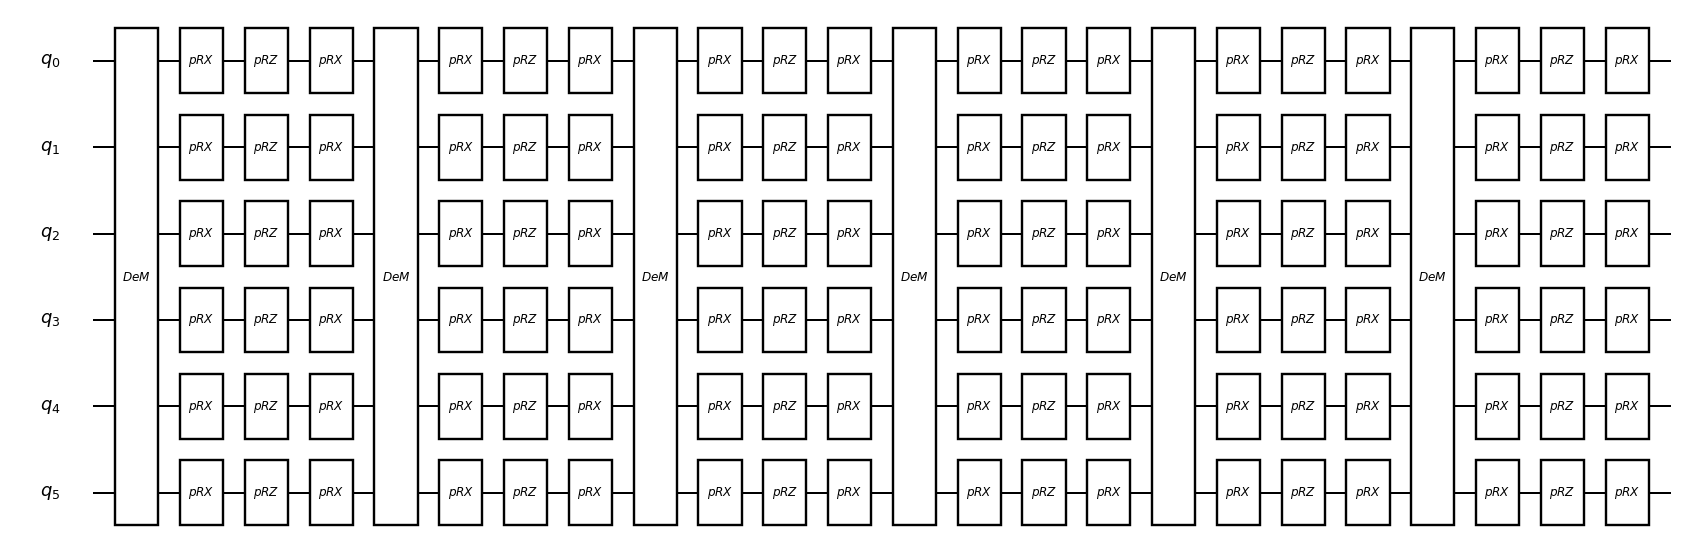

In [30]:
circuit_drawer(U_out,'mpl')

La clase ```ParametricQuantumCircuit``` de qulacs permite crear un circuito cuántico con compuertas que dependen de parámetros que pueden ser actualizados. 

Luego, definimos una función  ```set_U_out``` que permite actualizar $\theta$ en $U(\theta)$ 

In [18]:
# Function that updates parameter theta
def set_U_out(theta):
    global U_out

    parameter_count = U_out.get_parameter_count()

    for i in range(parameter_count):
        U_out.set_parameter(i, theta[i])

### Medidas

Tomaremos como output los valores de expectación asociados a los valores de expectación de la magentización en z de los primeros 5 qubits **del circuito**. 

En este caso, no aplicamos ninguna función para transformarlos. Es decir, el valor de expectación del i-ésimo qubit representa la predicción del i-ésimo spin del sistema real.

In [19]:
z0 = Observable(nqubit)
z0.add_operator(1.,'Z 0') 
z1 = Observable(nqubit)
z1.add_operator(1.,'Z 1') 
z2 = Observable(nqubit)
z2.add_operator(1.,'Z 2') 
z3 = Observable(nqubit)
z3.add_operator(1.,'Z 3') 
z4 = Observable(nqubit)
z4.add_operator(1.,'Z 4') 

def get_output(state):

    z0_val = z0.get_expectation_value(state)
    z1_val = z1.get_expectation_value(state)
    z2_val = z2.get_expectation_value(state)
    z3_val = z3.get_expectation_value(state)
    z4_val = z4.get_expectation_value(state)
    return np.asarray([z0_val, z1_val, z2_val,z3_val,z4_val])

### Repaso

Hasta ahora tenemos:
- Datos Etiquetados y su compuerta de codificación
- Circuito Parametrizado inicializado al azar
- Operadores de medición definidos

$\to$ Ya podemos empezar la optimización!

### Cálculo de $y(\theta \ , x_i)$

Definimos la función ```qcl_pred``` para calcular para cada entrada las predicciones provistas por $U_{out}$ para cada conjunto de parámetros ($\mathbf{\theta}$). 
1. Inicializamos el estado en $\ket{000000}$
2. Codificamos el valor $x$ de la entrada usando $U_{in}$
3. Aplicamos el circuito parametrizado $U_{out}$
4. Medimos usando la función ```get_output```

In [20]:
# Function that gives prediction value y(x_i, theta) of the model from input x_i
def qcl_pred(x, U_out):
    state = QuantumState(nqubit)
    state.set_zero_state()

    # Calculate input state
    U_in(x).update_quantum_state(state)

    # Calculate output state
    U_out.update_quantum_state(state)

    # Output of the model
    res = get_output(state)

    return res

### Función costo
Utilizamos como función perdida el error cuadrático medio.

In [21]:
def quadratic_loss(y_true, y_pred):
    return np.mean((np.array(y_true) - np.array(y_pred))**2)

Luego, definimos la función costo a minimizar que será llamada en cada instancia de la minimización. Lo que hace es actualizar el valor de theta, calcular la predicción y calcular el error cuadrático medio.

In [22]:
# Calculate cost function L
def cost_func(theta):
    
    # update the parameter theta of U_out
    # global U_out
    set_U_out(theta)

    # calculate basing on data of num_x_train in total
    y_pred = [qcl_pred(x, U_out) for x in x_times]

    # quadratic loss
    L = quadratic_loss(train_results, y_pred)

    return L

# Resultados

Minimizamos usando el método BFGS

In [23]:
from scipy.optimize import minimize
result = minimize(cost_func, theta_init, method='BFGS', options = {'maxiter':5000}) 

Una vez que tenemos el resultado de la minimización, evaluamos el circuito en ese valor y testeamos.

In [24]:
# Solution of theta by optimization
theta_opt = result.x
print(result.fun)
print(result.x)

# Insert optimized theta into U_out
set_U_out(theta_opt)

# Create xlist
xlist = np.linspace(-1, 1, 100)

# Generate predictions
z_predictions = [np.array([qcl_pred(x, U_out)[i] for x in xlist]) for i in range(5)]

2.3245588108622198e-05
[4.80306375 2.89567599 5.22329672 0.71676219 3.56866996 1.02169377
 5.54864397 2.97434843 2.97524696 1.18050458 5.17737199 2.93562148
 3.67102755 0.14790735 3.9827754  3.42454523 3.87498003 6.39408048
 4.4617495  2.1337003  2.81348203 4.26868385 0.05574439 4.38108777
 4.31301947 1.46461251 0.49310131 1.98120666 2.23974118 3.37819512
 2.75375477 5.89944391 0.65508875 1.65460808 1.47495818 4.23060204
 1.46330718 2.91425369 1.47223952 0.99680878 0.69712463 4.21755995
 0.62877079 0.98838293 2.53109815 5.14303051 0.80142935 5.28237521
 0.69200599 6.13335183 3.03931516 6.37369973 3.82642526 4.10895579
 0.42968127 1.60614826 1.0352799  2.11934195 0.33761906 2.34009183
 2.74056891 0.6944171  4.25557366 3.63072124 1.31163177 3.43640441
 0.79151431 3.32724576 5.61211516 2.10399016 4.23961586 1.26899003
 4.36252224 1.90572141 0.84081841 3.5293281  0.17629725 5.0152179
 0.09766547 4.44912591 1.86804563 4.72616516 6.06869324 1.69930218
 3.80573191 3.70549473 3.4179842  1.2349

# Resultados finales del modelo

In [ ]:

# Darker shades

dark_colors = ['#061837', '#E21A1A', '#002C03', '#430067', '#FFA283']

# Lighter shades
light_colors = ['#0079FF', '#AC4D62', '#00FF13', '#885B98', '#A14B00']



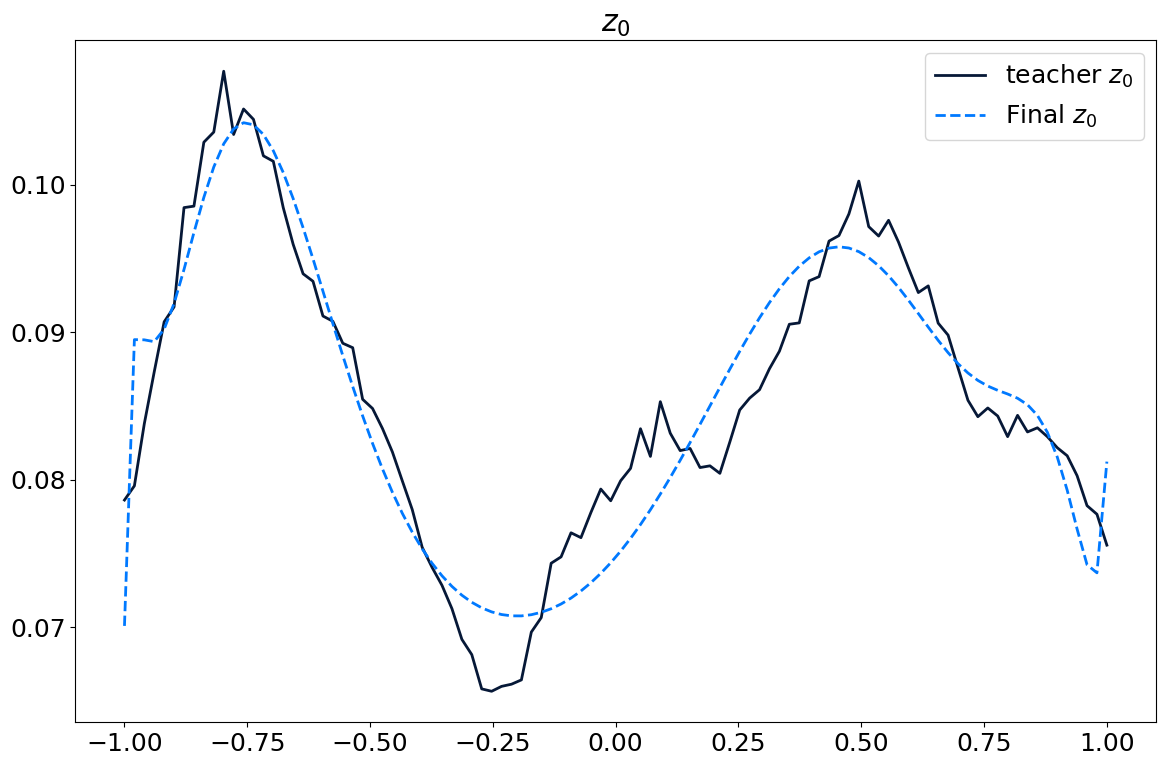

In [31]:
fig, axs = plt.subplots(1, figsize=(12,8)); i = 0
# Plot individual quantities
axs.plot(x_times, [step[i] for step in train_results], label='teacher $z_{}$'.format(i), color=dark_colors[i], linewidth=2); axs.plot(xlist, z_predictions[i], label=f'Final $z_{i}$', linestyle='--', color=light_colors[i], linewidth=2)
axs.legend(); axs.set_title(f'$z_{i}$', ); plt.tight_layout(); plt.show()

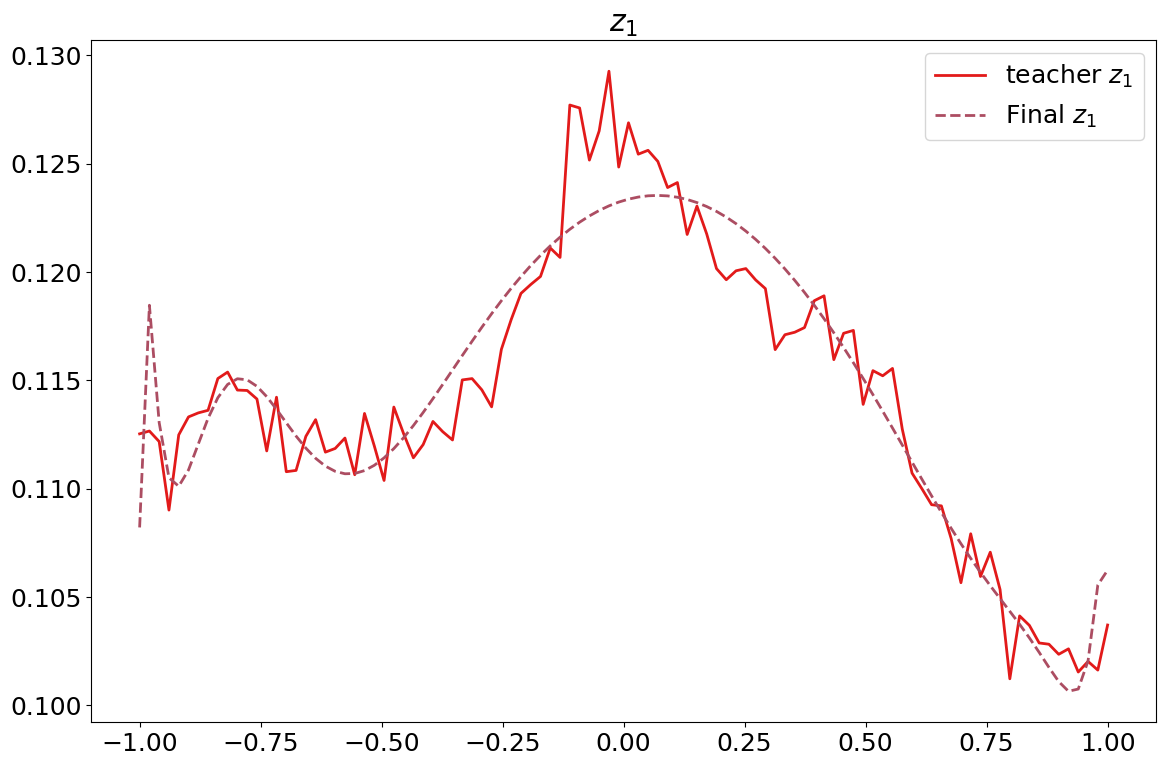

In [27]:
fig, axs = plt.subplots(1, figsize=(12,8)); i = 1
axs.plot(x_times, [step[i] for step in train_results], label='teacher $z_{}$'.format(i), color=dark_colors[i], linewidth=2); axs.plot(xlist, z_predictions[i], label=f'Final $z_{i}$', linestyle='--', color=light_colors[i], linewidth=2)
axs.legend(); axs.set_title(f'$z_{i}$', ); plt.tight_layout(); plt.show()

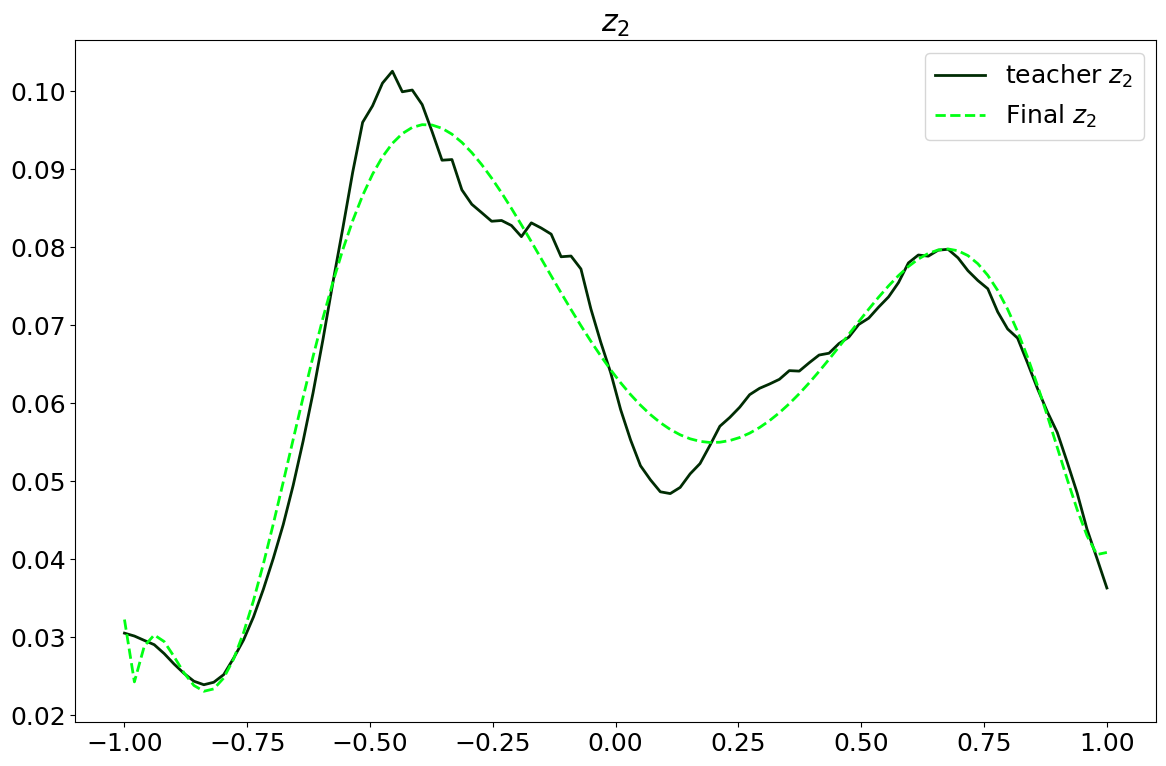

In [28]:
fig, axs = plt.subplots(1, figsize=(12,8)); i = 2
axs.plot(x_times, [step[i] for step in train_results], label='teacher $z_{}$'.format(i), color=dark_colors[i], linewidth=2); axs.plot(xlist, z_predictions[i], label=f'Final $z_{i}$', linestyle='--', color=light_colors[i], linewidth=2)
axs.legend(); axs.set_title(f'$z_{i}$', ); plt.tight_layout(); plt.show()

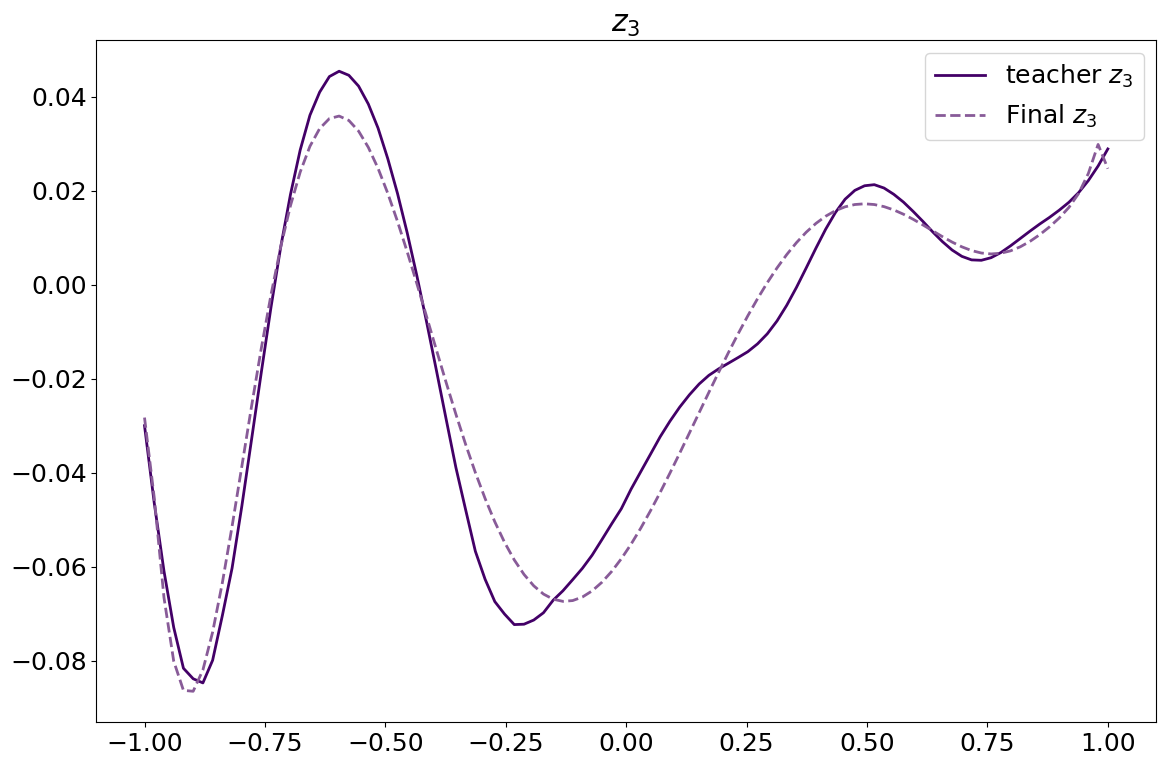

In [29]:
fig, axs = plt.subplots(1, figsize=(12,8)); i = 3
axs.plot(x_times, [step[i] for step in train_results], label='teacher $z_{}$'.format(i), color=dark_colors[i], linewidth=2); axs.plot(xlist, z_predictions[i], label=f'Final $z_{i}$', linestyle='--', color=light_colors[i], linewidth=2)
axs.legend(); axs.set_title(f'$z_{i}$', ); plt.tight_layout(); plt.show()

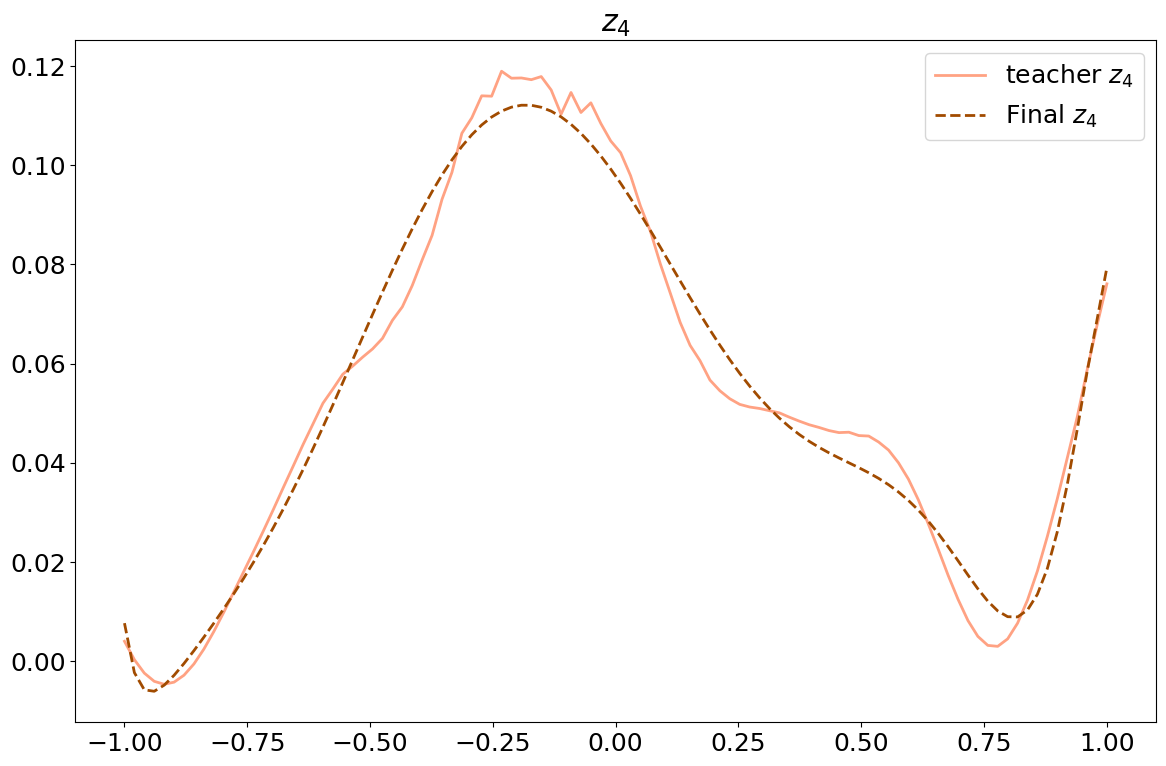

In [30]:
fig, axs = plt.subplots(1, figsize=(12,8)); i = 4
axs.plot(x_times, [step[i] for step in train_results], label='teacher $z_{}$'.format(i), color=dark_colors[i], linewidth=2); axs.plot(xlist, z_predictions[i], label=f'Final $z_{i}$', linestyle='--', color=light_colors[i], linewidth=2)
axs.legend(); axs.set_title(f'$z_{i}$', ); plt.tight_layout(); plt.show()

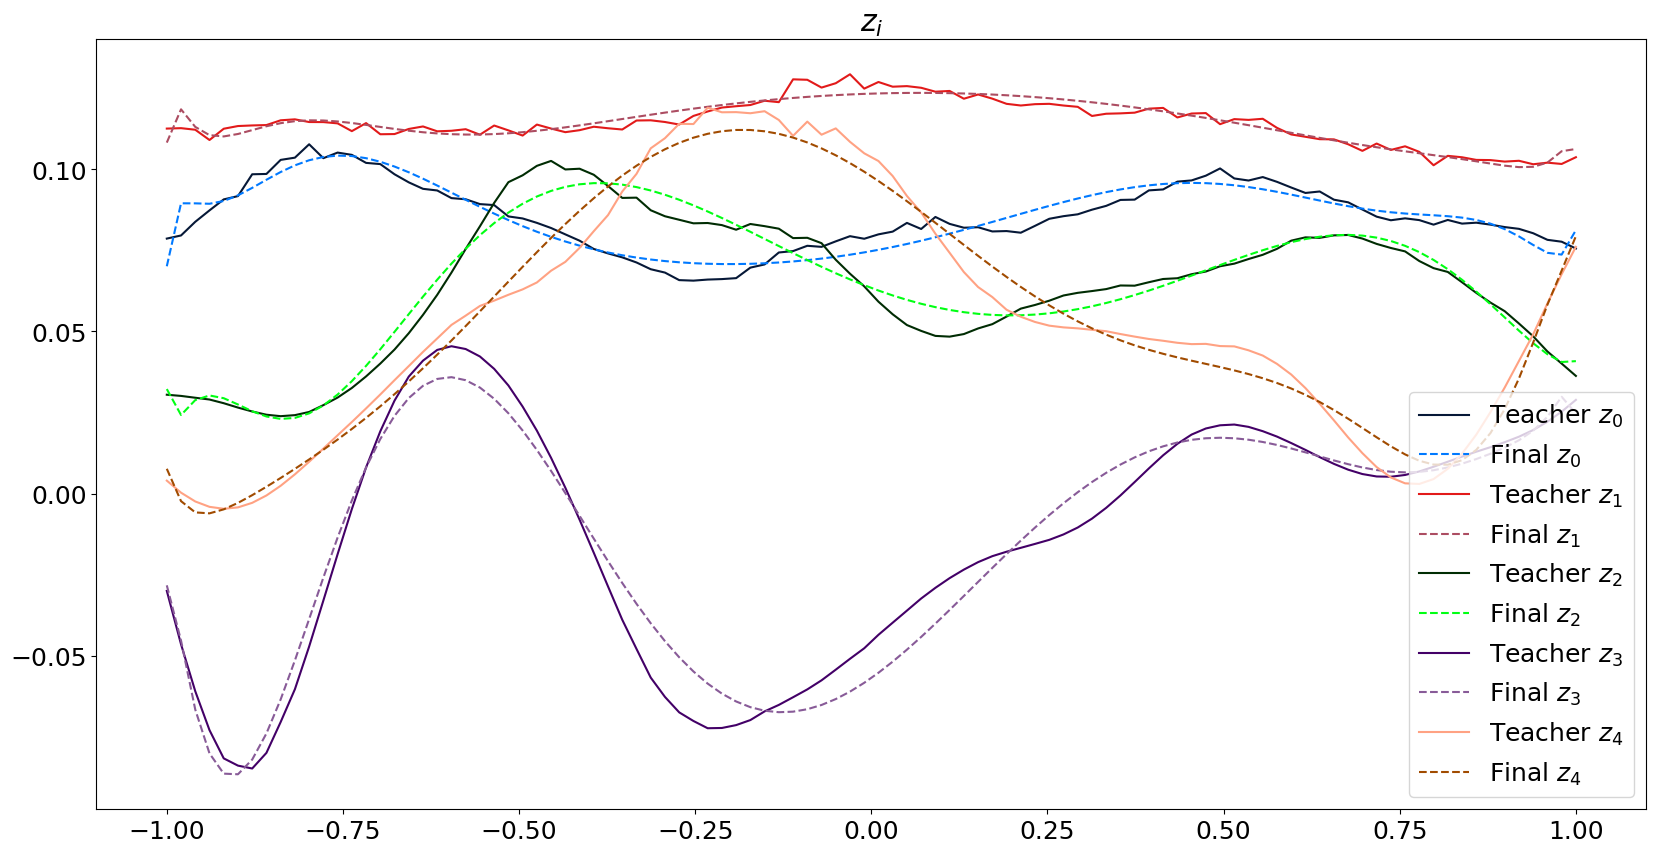

In [26]:
# Create a 2x3 subplot
fig, axs = plt.subplots(1, figsize=(20, 10))
# Plot individual quantities
for i in range(5):
    axs.plot(x_times, [step[i] for step in train_results], label='Teacher $z_{}$'.format(i), color=dark_colors[i])
    axs.plot(xlist, z_predictions[i], label=f'Final $z_{i}$', linestyle='--', color=light_colors[i])
    axs.legend(loc='lower right')
    axs.set_title(f'$z_i$')
plt.show()

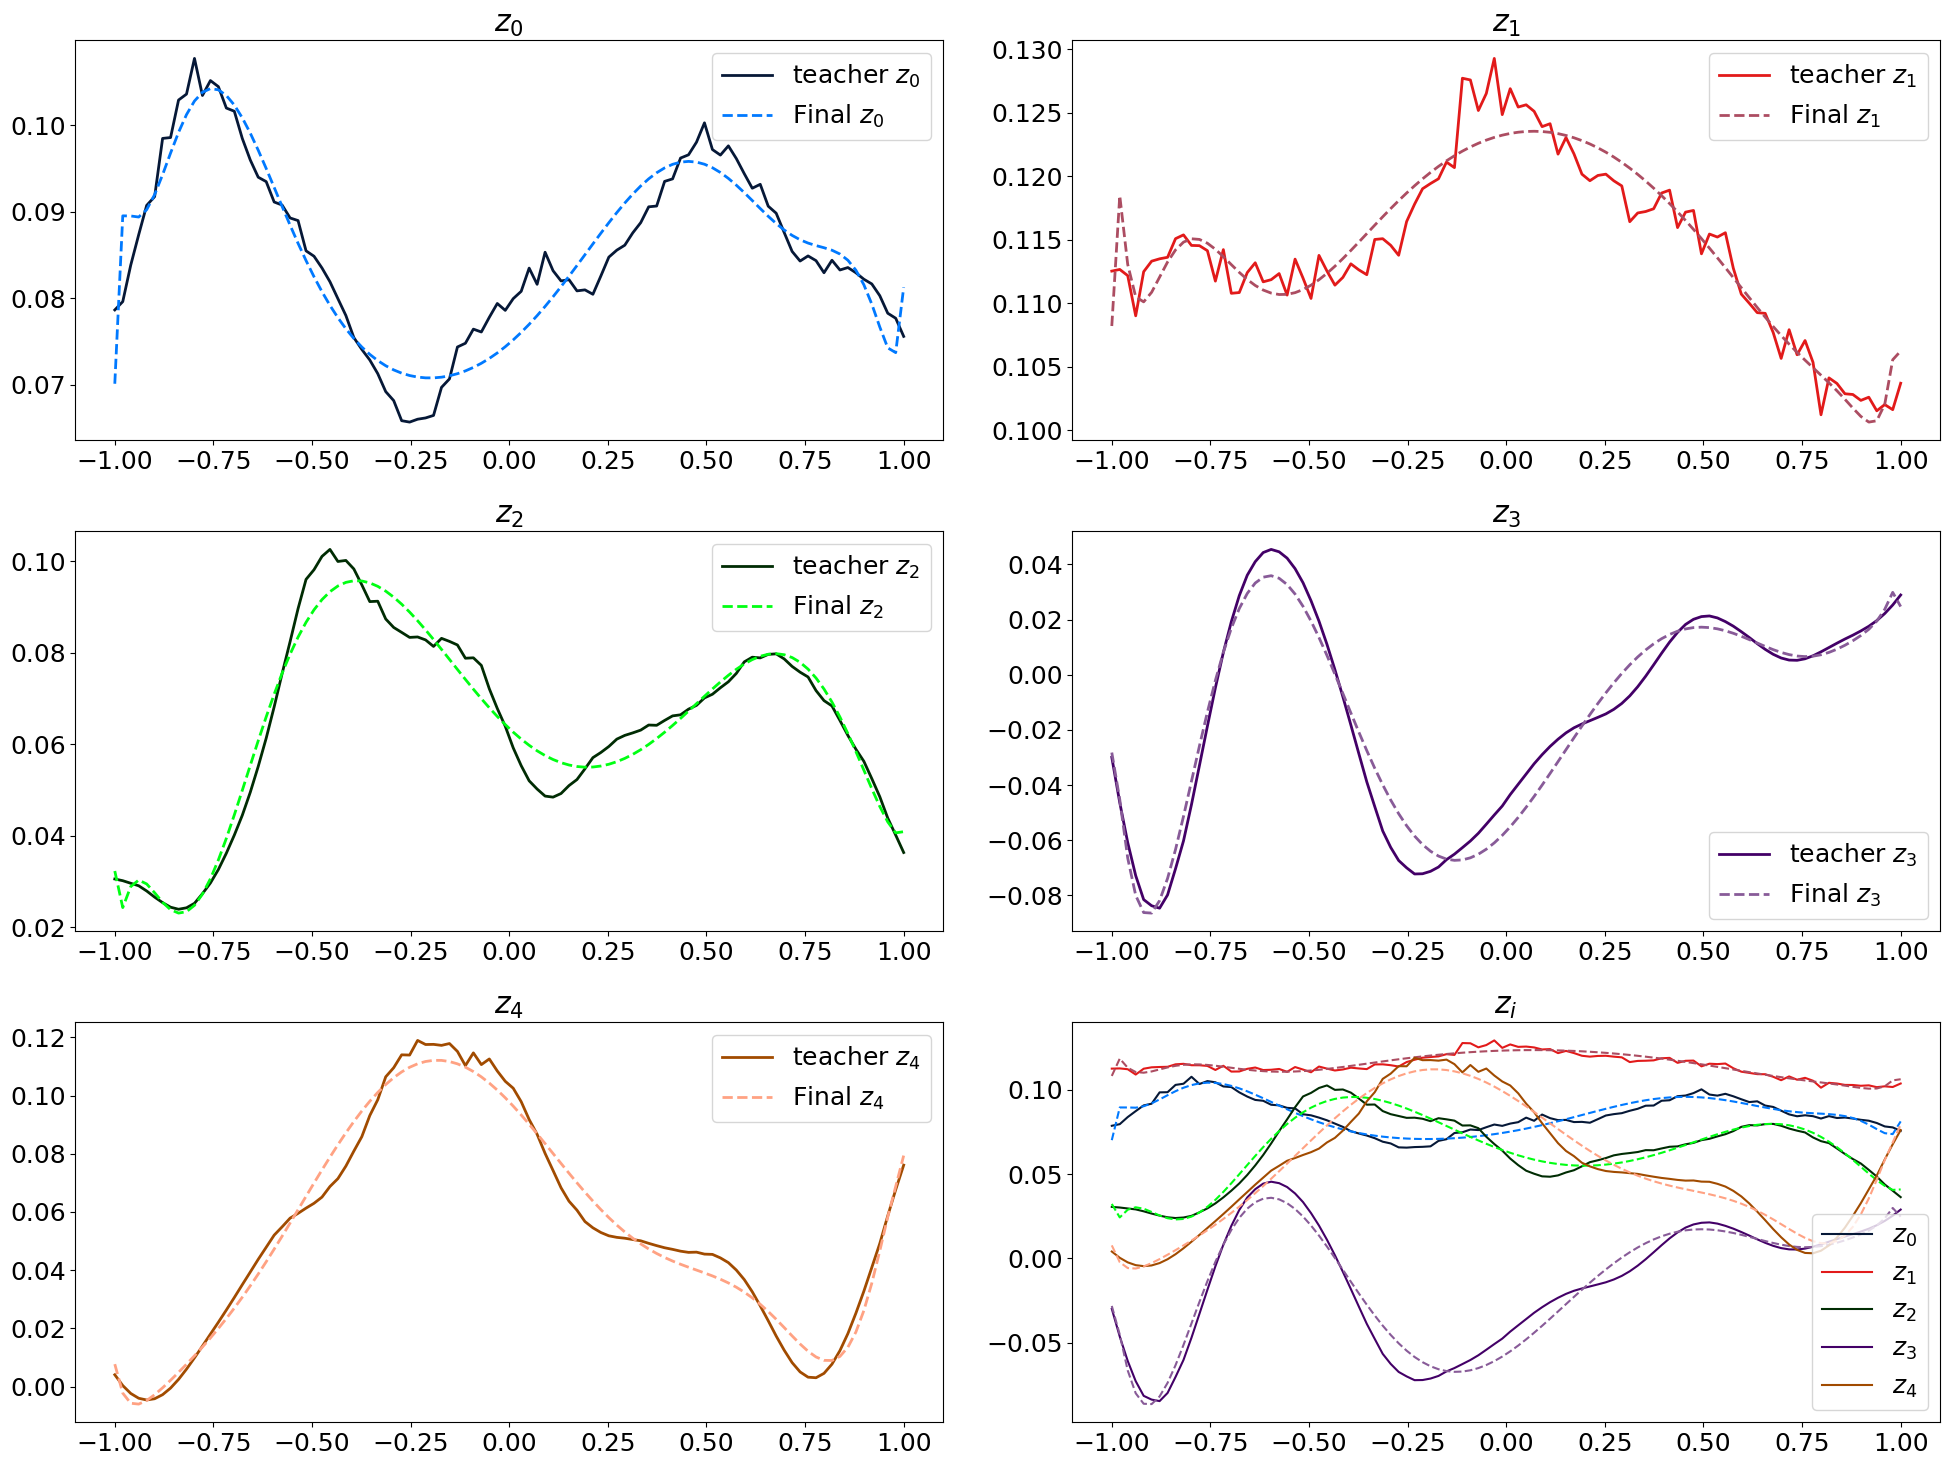

In [ ]:
# Insert optimized theta into U_out
set_U_out(theta_opt)

# Create xlist
xlist = np.linspace(-1, 1, 100)

# Generate predictions
z_predictions = [np.array([qcl_pred(x, U_out)[i] for x in xlist]) for i in range(5)]

# Create a 3x2 subplot
fig, axs = plt.subplots(3, 2, figsize=(20,15))


# Darker shades
dark_colors = ['#061837', '#E21A1A', '#002C03', '#430067', '#A14B00']

# Lighter shades
light_colors = ['#0079FF', '#AC4D62', '#00FF13', '#885B98', '#FFA283']

# Plot individual quantities
for i in range(4):
    axs[i//2, i%2].plot(x_times, [step[i] for step in train_results], label='teacher $z_{}$'.format(i), color=dark_colors[i], linewidth=2)
    axs[i//2, i%2].plot(xlist, z_predictions[i], label=f'Final $z_{i}$', linestyle='--', color=light_colors[i], linewidth=2)
    axs[i//2, i%2].legend()
    axs[i//2, i%2].set_title(f'$z_{i}$', )

# Plot z4 in the third row
axs[2, 0].plot(x_times, [step[4] for step in train_results], label='teacher $z_4$', color=dark_colors[4], linewidth=2)
axs[2, 0].plot(xlist, z_predictions[4], label='Final $z_4$', linestyle='--', color=light_colors[4], linewidth=2)
axs[2, 0].legend()
axs[2, 0].set_title('$z_4$')

# Plot all together in the last subplot
for i in range(5):
    axs[2, 1].plot(x_times, [step[i] for step in train_results], label='$z_{}$'.format(i), color=dark_colors[i])
    axs[2,1].plot(xlist, z_predictions[i], linestyle='--', color=light_colors[i])
    axs[2,1].legend(loc='lower right')
    axs[2,1].set_title(f'$z_i$')

plt.tight_layout()
plt.show()
